## Empirical Bayes experiments - different datasets and prior weightings

In [1]:
# metacriticisms about this notebook - it's not sufficiently commented, has a lot of redundant code (misunderstanding
# between dplyr's transmute and mutate functions) and overall is too confusing to be presented as any kind of supplement
# for a paper. We'll need to do a more thorough pass over this in future.

### Step 0: packages and hyperparameters

In [1]:
# test modification

library(data.table)
library(tidyverse)
library(distr)
library(DescTools)
library(DirichletReg)

── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()

Loading required package: startupmsg

Utilities for Start-Up Messages (version 0.9.6)

For more information see ?"startupmsg", NEWS("startupmsg")


Loading required pa

In [2]:
MAP_EST = FALSE # if set to false uses posterior mean instead - this leads to a more reasonable interp of confidence interval

### Step 1: load in the data and split it into train and test sets

In [3]:
# raw_df = read.csv("data/Gift_Cards.csv", header = FALSE, col.names=c("item", "user", "rating", "timestamp"))
raw_df = read.csv("data/Video_Games_raw.csv", header = FALSE, col.names=c("item", "user", "rating", "timestamp"))
# raw_df = read.csv("data/Prime_Pantry.csv", header = FALSE, col.names=c("item", "user", "rating", "timestamp"))

set.seed(1729)

df <- count(raw_df, item)
df <- merge(raw_df, df, by='item')
temp_df <- group_by(df, item) %>% summarize(avg = mean(rating))
df <- merge(df, temp_df, by='item')

in.train = sample(unique(df$item), size = 0.6*length(unique(df$item)))
df.train = filter(df, item %in% in.train)
df.test = filter(df, !item %in% in.train)

In [4]:
write.csv(distinct(select(filter(df, n >= 20), c(item, avg))),'amazonfig1.csv')

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



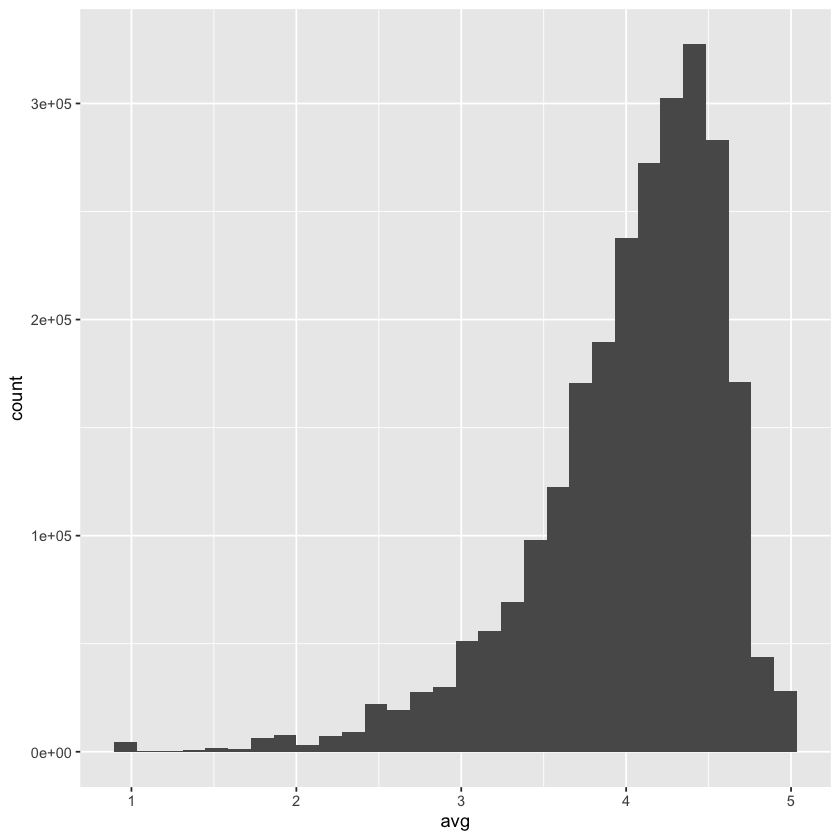

In [5]:
ggplot(df) + geom_histogram(aes(x = avg))

In [6]:
nrow(raw_df)

[1] 2565349

### Step 2: Train the EB model (categorical with Dirichlet prior)

In [7]:
prior_df <- dcast(setDT(df.train), item ~ rating, fun.aggregate = length)

colnames(prior_df) <- c("item", "n1", "n2", "n3", "n4", "n5")

prior_df$n = prior_df$n1 + prior_df$n2 + prior_df$n3 + prior_df$n4 + prior_df$n5

prior_df <- filter(prior_df, n >= 20)

# remove all columns with a 0 count for one category
prior_df  <- transmute(prior_df, n1 = n1 / n, n2 = n2 / n, n3 = n3 / n, n4 = n4 / n, n5 = n5 / n) %>% 
  filter(n1 != 0 & n2 != 0 & n3 != 0 & n4 != 0 & n5 != 0)

log_p <- summarize(prior_df, summarize(prior_df, n1 = sum(log(n1)), n2 = sum(log(n2)), n3 = sum(log(n3)), n4=sum(log(n4)), n5=sum(log(n5))))
log_p <- as.numeric(log_p[1,])

print(log_p)
# gift cards log-p: -558.81647 -798.35765 -708.34644 -518.60578  -36.76743
# video games log-p: -19110.579 -23947.009 -20340.458 -15104.914  -5944.121
# prime pantry log-p: -5113.2916 -5570.4004 -4816.4874 -3816.7264  -770.3125

N <- nrow(prior_df)

# start from a totally uninformed prior
alphas = c(1,1,1,1,1)

# actual training function

fp_step <- function(alphas, log_p, N) {
  return(igamma(rep(digamma(sum(alphas)), 5) + log_p/N))
}

[1] -19558.415 -24494.460 -20864.503 -15492.412  -6101.177


In [8]:
# this step must be repeated many times.
# gift card alphas: 18.41389   4.77803   7.56642  21.55294 309.98082
# video game alphas: 2.026083 1.318121 1.806632 3.009980 8.200924
# prime pantry alphas: 2.360188  1.927949  2.705008  4.389483 22.445298
alphas <- fp_step(alphas, log_p, N)
b = sum(alphas)
print(alphas)

[1] 0.8680138 0.6393817 0.7963963 1.1645443 2.6651608


In [9]:
# check if stability achieved

for (i in c(1:100)) {
    alphas <- fp_step(alphas,log_p,N)
}
print(alphas)

[1] 2.000377 1.304987 1.776889 2.958382 8.056539


In [10]:
alphas_b = alphas/sum(alphas)
print(alphas_b)

[1] 0.12426885 0.08106932 0.11038518 0.18378269 0.50049396


### Step 3: Prepare the various testing methods

In [11]:
df.test <- filter(df.test, n >= 100) %>%
  group_by(item) %>% 
  arrange(timestamp, .by_group = TRUE) %>%
  slice_head(n=100)

#split test set in half
df.test_learn = group_by(df.test, item) %>% 
  arrange(timestamp, .by_group = TRUE) %>%
  slice_head(n=50)
df.test_eval = group_by(df.test, item) %>% 
  arrange(timestamp, .by_group = TRUE) %>%
  slice_tail(n=50)

# set up evaluation dataset for evaluating
df.test_eval <- dcast(setDT(df.test_eval), item ~ rating, fun.aggregate = length) %>% arrange(item)
colnames(df.test_eval) <- c("item", "n1", "n2", "n3", "n4", "n5")
df.test_eval$n = df.test_eval$"n1" + df.test_eval$"n2" + df.test_eval$"n3" + df.test_eval$"n4" + df.test_eval$"n5"
df.test_eval <- transmute(df.test_eval, item=item, n1 = n1 / n, n2 = n2 / n, n3 = n3 / n, n4 = n4 / n, n5 = n5 / n)

num_eval_products = nrow(df.test_eval)

df.test_learn_copy = df.test_learn
df.test_eval_copy = df.test_eval

#### Step 3.1 - Over-time test of EB compared with frequentist

In [30]:
# start training and checking performance at each step
items = unique(df.test_learn$item)

mses_f = tibble(items)
mses_b = tibble(items)
kls_f = tibble(items)
kls_b = tibble(items)
avg_f = tibble(items)
avg_b = tibble(items)

for (i in c(1:50)) {
  df.test_learn_subset = group_by(df.test_learn, item) %>%
    arrange(timestamp, .by_group = TRUE) %>%
    slice_head(n=i)

  df.test_learn_subset <- dcast(setDT(df.test_learn_subset), item ~ rating, fun.aggregate = length, drop=FALSE) %>% arrange(item)
  
  # adding missing columns
  for (j in setdiff(c("item", "1", "2", "3", "4", "5"), colnames(df.test_learn_subset))) {
    df.test_learn_subset[[j]] <- rep(0, num_eval_products)
  }
  df.test_learn_subset <- df.test_learn_subset[,c("item", "1", "2", "3", "4", "5")]
  
  colnames(df.test_learn_subset) <- c("item", "n1", "n2", "n3", "n4", "n5")
  df.test_learn_subset$n = df.test_learn_subset$"n1" + df.test_learn_subset$"n2" + df.test_learn_subset$"n3" + df.test_learn_subset$"n4" + df.test_learn_subset$"n5"

  df.test_learn_f <- transmute(df.test_learn_subset, item=item, n1 = n1 / n, n2 = n2 / n, n3 = n3 / n, n4 = n4 / n, n5 = n5 / n)
  df.test_learn_b <- mutate(df.test_learn_subset, item=item, b1 = n1 + alphas[1], b2 = n2 + alphas[2], b3 = n3 + alphas[3],
         b4 = n4 + alphas[4], b5 = n5 + alphas[5], b = n + sum(alphas))
    
  if (MAP_EST) {
      df.test_learn_b <- mutate(df.test_learn_b, b1 = (b1-1) / (b-5), b2 = (b2-1) / (b-5), b3 = (b3-1) / (b-5), b4 = (b4-1) / (b-5), b5 = (b5-1) / (b-5))
  } else {
      df.test_learn_b <- mutate(df.test_learn_b, b1 = b1 / b, b2 = b2 / b, b3 = b3 / b, b4 = b4 / b, b5 = b5 / b)
  }
    
  # prep datasets for evaluation
  df.test_eval_modified <- select(df.test_eval, c(n1, n2, n3, n4, n5))
  df.test_learn_b <- select(df.test_learn_b, c(b1, b2, b3, b4, b5))
  df.test_learn_f <- select(df.test_learn_f, c(n1, n2, n3, n4, n5))

  f_mse = rowSums((df.test_learn_f - df.test_eval_modified)^2)
  b_mse = rowSums((df.test_learn_b - df.test_eval_modified)^2)
  f_kl = rowSums(df.test_eval_modified*log(df.test_eval_modified/df.test_learn_f), na.rm = TRUE)
  f_kl[!is.finite(f_kl)] = 1
  b_kl = rowSums(df.test_eval_modified*log(df.test_eval_modified/df.test_learn_b), na.rm = TRUE)
  b_kl[!is.finite(b_kl)] = 1
    
  f_av = ((df.test_learn_f$n1 + 2*df.test_learn_f$n2 + 3*df.test_learn_f$n3 + 4*df.test_learn_f$n4 + 5*df.test_learn_f$n5)
                 - (df.test_eval_modified$n1 + 2*df.test_eval_modified$n2 + 3*df.test_eval_modified$n3 + 4*df.test_eval_modified$n4 + 5*df.test_eval_modified$n5))^2
  b_av = ((df.test_learn_b$b1 + 2*df.test_learn_b$b2 + 3*df.test_learn_b$b3 + 4*df.test_learn_b$b4 + 5*df.test_learn_b$b5)
                 - (df.test_eval_modified$n1 + 2*df.test_eval_modified$n2 + 3*df.test_eval_modified$n3 + 4*df.test_eval_modified$n4 + 5*df.test_eval_modified$n5))^2
  
  mses_f[[i]] = f_mse
  mses_b[[i]] = b_mse
  kls_f[[i]] = f_kl
  kls_b[[i]] = b_kl
  avg_f[[i]] = f_av
  avg_b[[i]] = b_av

}

mses_f = tibble(val = colSums(mses_f) / num_eval_products, method = "freq", idx=c(1:length(mses_f)))
mses_b = tibble(val = colSums(mses_b) / num_eval_products, method = "eb", idx=c(1:length(mses_b)))
kls_f = tibble(val = colSums(kls_f) / num_eval_products, method = "freq", idx=c(1:length(kls_f)))
kls_b = tibble(val = colSums(kls_b) / num_eval_products, method = "eb", idx=c(1:length(kls_b)))
avg_f = tibble(val = colSums(avg_f) / num_eval_products, method = "freq", idx=c(1:length(avg_f)))
avg_b = tibble(val = colSums(avg_b) / num_eval_products, method = "eb", idx=c(1:length(avg_b)))

mses = rbind(mses_f,mses_b)
kls = rbind(kls_f,kls_b)
avgs = rbind(avg_f,avg_b)

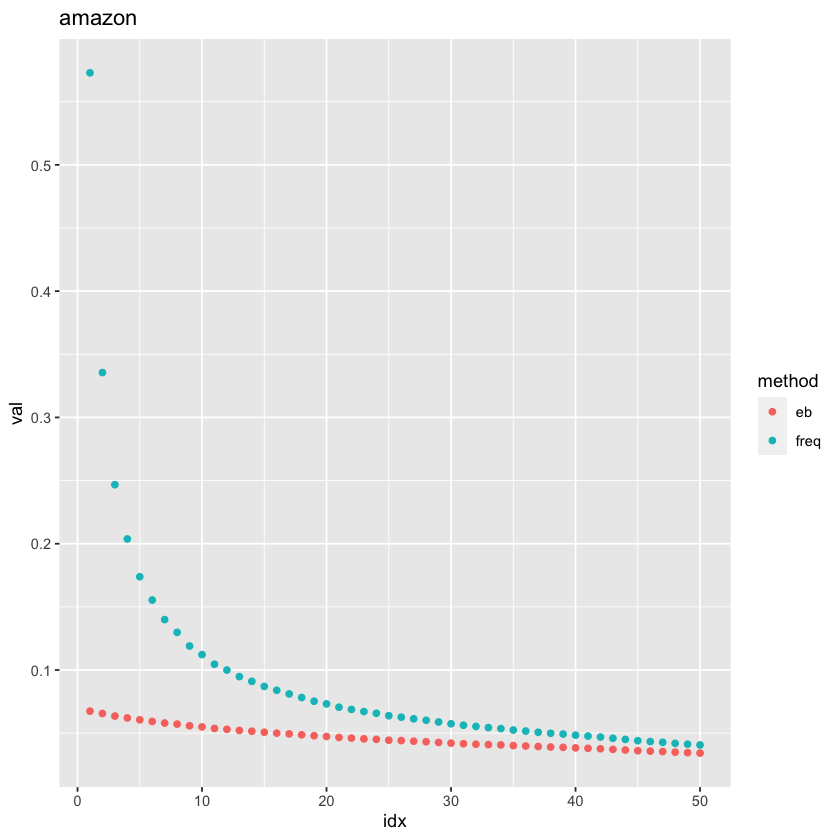

In [34]:
# Plot MSE loss

ggplot(mses, aes(x=idx, y=val, color=method)) +
  geom_point() +
  ggtitle("amazon")

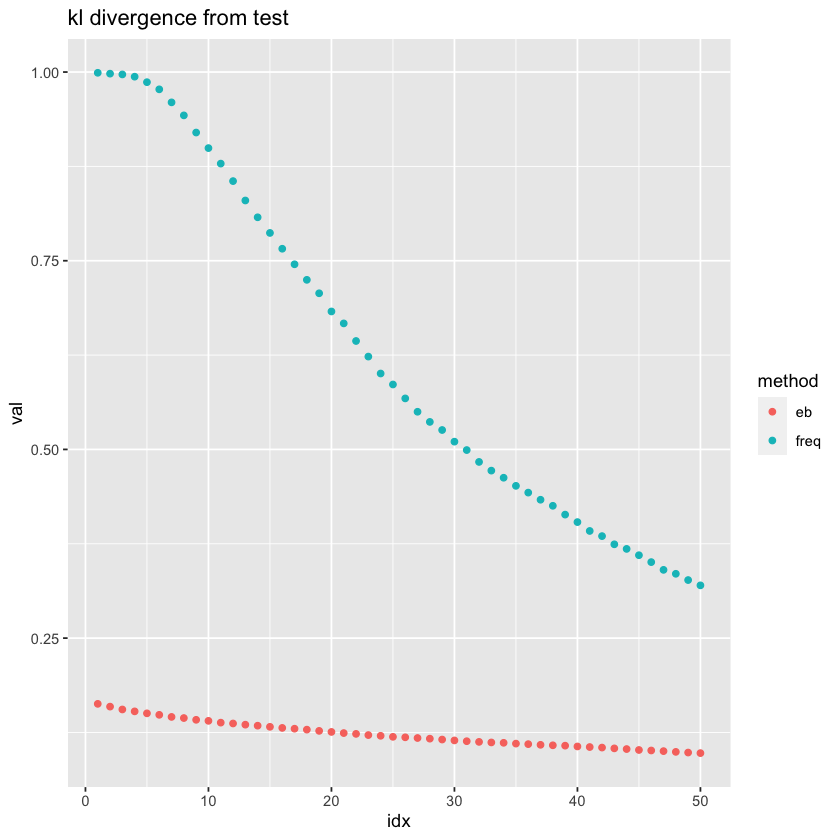

In [32]:
# Plot kl divergence

ggplot(kls, aes(x=idx, y=val, color=method)) +
  geom_point() +
  ggtitle("kl divergence from test")

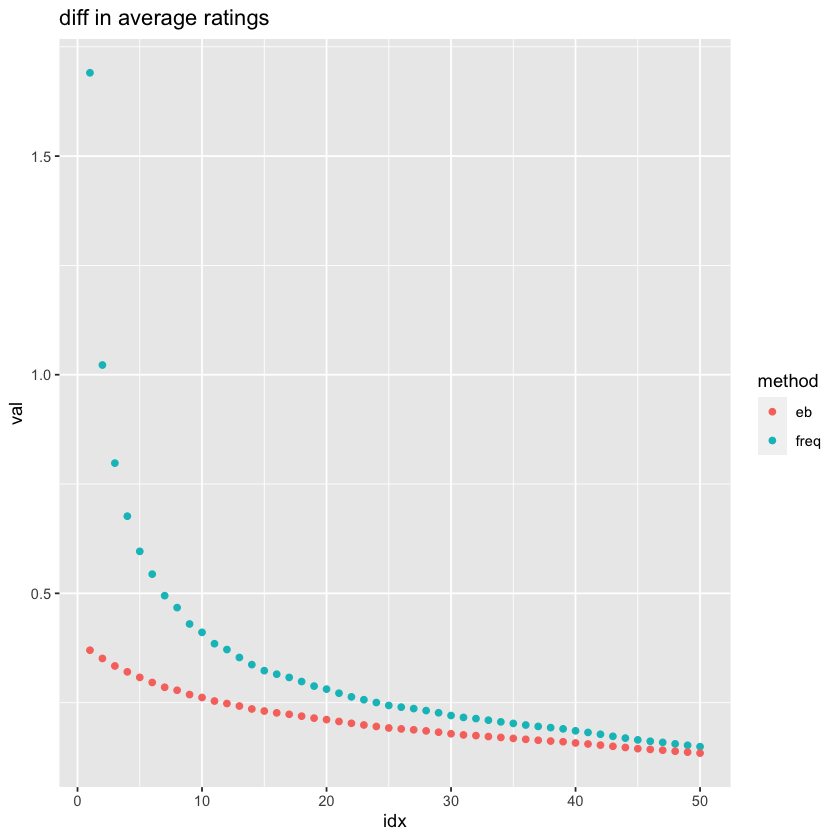

In [33]:
# Plot loss in calculating average

ggplot(avgs, aes(x=idx, y=val, color=method)) +
  geom_point() +
  ggtitle("diff in average ratings")

#### Step 3.2 Facet grid of MSE loss over train sample stratified by average rating

In [52]:
test_learn_agg <- dcast(setDT(df.test), item ~ rating, fun.aggregate = length)
colnames(test_learn_agg) <- c('item', 'n1', 'n2', 'n3', 'n4', 'n5')
test_learn_agg <- test_learn_agg %>% mutate(n = n1 + n2 + n3 + n4 + n5)
test_learn_agg <- transmute(test_learn_agg, item=item, n1 = n1 / n, n2 = n2 / n, n3 = n3 / n, n4 = n4 / n, n5 = n5 / n)

In [53]:
test_subset = test_learn_agg %>% mutate(avg = (n1+2*n2+3*n3+4*n4+5*n5))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



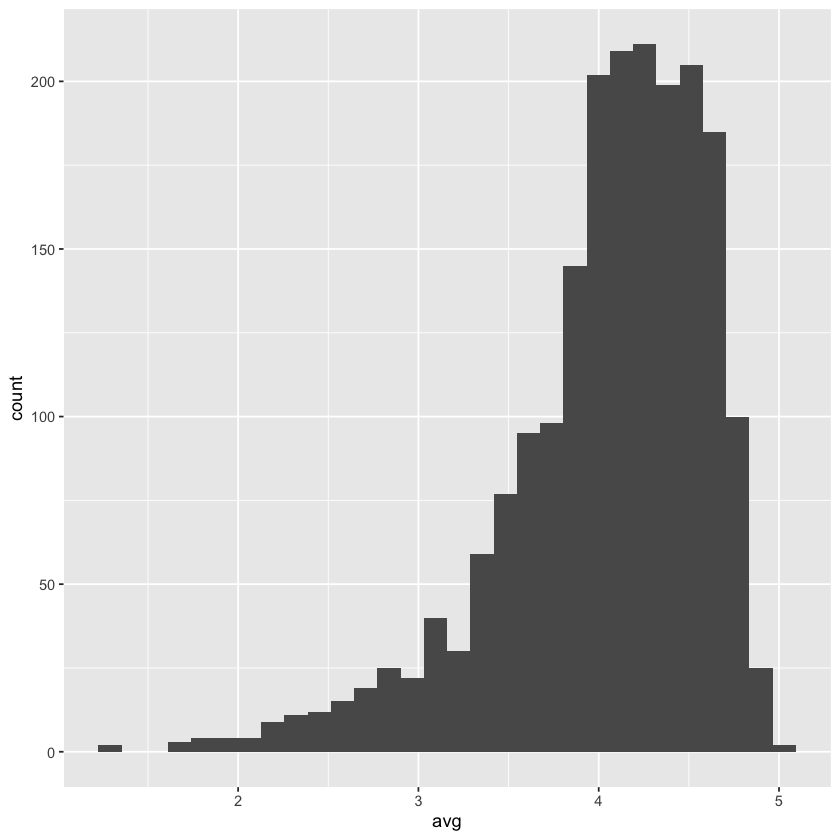

In [54]:
ggplot(test_subset, aes(x=avg)) +
    geom_histogram()

In [42]:
results_df = data.frame(matrix(ncol=5,nrow=0))

for (i in c(1, 3, 5, 10, 20, 50)) {
  df.test_learn_subset = group_by(df.test_learn, item) %>%
    filter(item %in% test_subset$item) %>%
    arrange(timestamp, .by_group = TRUE) %>%
    slice_head(n=i)
    
  df.test_learn_subset <- dcast(setDT(df.test_learn_subset), item ~ rating, fun.aggregate = length, drop=FALSE) %>% arrange(item)
  
  # adding missing columns
  for (j in setdiff(c("item", "1", "2", "3", "4", "5"), colnames(df.test_learn_subset))) {
    df.test_learn_subset[[j]] <- rep(0, num_eval_products)
  }
  df.test_learn_subset <- df.test_learn_subset[,c("item", "1", "2", "3", "4", "5")]
    
  colnames(df.test_learn_subset) <- c("item", "n1", "n2", "n3", "n4", "n5")
  df.test_learn_subset$n = df.test_learn_subset$"n1" + df.test_learn_subset$"n2" + df.test_learn_subset$"n3" + df.test_learn_subset$"n4" + df.test_learn_subset$"n5"
    
  df.test_learn_f <- transmute(df.test_learn_subset, item=item, n1 = n1 / n, n2 = n2 / n, n3 = n3 / n, n4 = n4 / n, n5 = n5 / n)
  df.test_learn_b <- mutate(df.test_learn_subset, item=item, b1 = n1 + alphas[1], b2 = n2 + alphas[2], b3 = n3 + alphas[3],
         b4 = n4 + alphas[4], b5 = n5 + alphas[5], b = n + sum(alphas))
  if (MAP_EST) {
      df.test_learn_b <- transmute(df.test_learn_b, item=item, b1 = (b1-1) / (b-5), b2 = (b2-1) / (b-5), b3 = (b3-1) / (b-5), b4 = (b4-1) / (b-5), b5 = (b5-1) / (b-5))
  } else {
      df.test_learn_b <- transmute(df.test_learn_b, item=item, b1 = b1 / b, b2 = b2 / b, b3 = b3 / b, b4 = b4 / b, b5 = b5 / b)
  }
    
  for (id in unique(test_subset$item)) {
      dist_b = filter(df.test_learn_b, item==id) %>% select(c(b1, b2, b3, b4, b5))
      dist_f = filter(df.test_learn_f, item==id) %>% select(c(n1, n2, n3, n4, n5))
      av = filter(test_subset, item==id)$avg
      dist_eval = filter(df.test_eval, item==id) %>% select(c(n1, n2, n3, n4, n5))
      
      to_add = c(id, sqrt(sum((dist_eval-dist_b)^2)), drop(av), i, 'eb')
      
      results_df <- rbind(results_df, to_add)
      
      to_add = c(id, sqrt(sum((dist_eval-dist_f)^2)), drop(av), i, 'freq')
      
      results_df <- rbind(results_df, to_add)
      
      to_add = c(id, sqrt(sum((dist_eval-alphas_b)^2)), drop(av), i, 'baseline')
      
      results_df <- rbind(results_df, to_add)
      
  }

}

colnames(results_df) <- c('item', 'dist', 'avg', 'num_train', 'method')

In [43]:
results_df$dist <- as.numeric(results_df$dist)
results_df$avg <- as.numeric(results_df$avg)
results_df$num_train <- as.numeric(results_df$num_train)

Warning message:
“Removed 541 rows containing missing values (geom_point).”


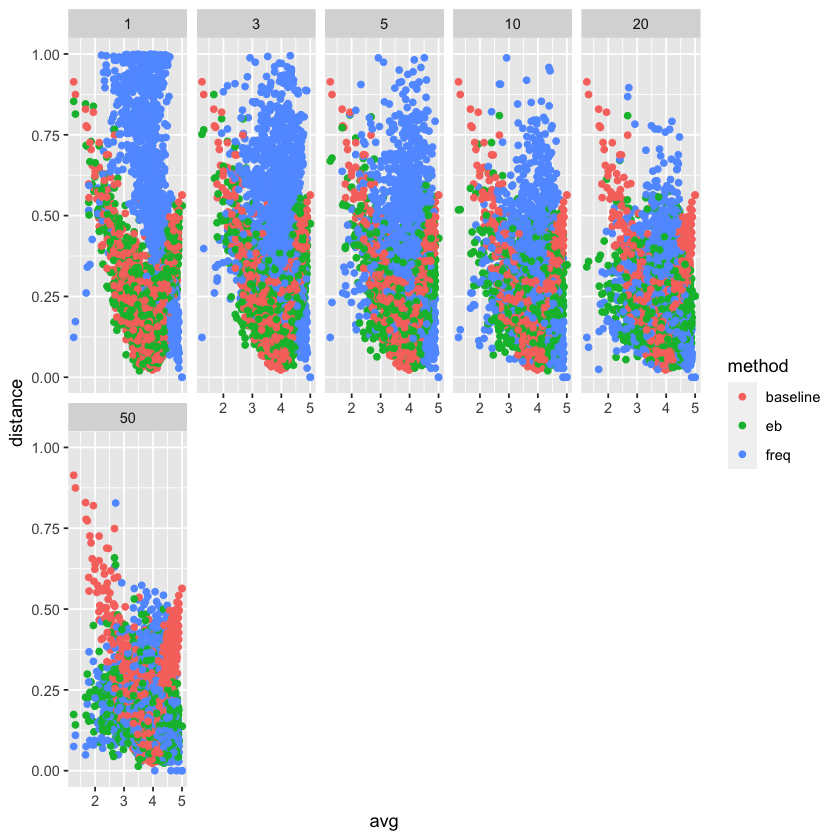

In [44]:
# Plot results

ggplot(results_df) + 
    geom_point(aes(x=avg, y=dist, color=method)) +
    facet_wrap(vars(num_train), ncol=5) +
    scale_y_continuous(name="distance", limits=c(0, 1))

In [57]:
avg_df <- results_df %>% 
           mutate(level=round(avg*2)/2) %>%
#           mutate(level=floor(avg)) %>%
          group_by(level, method, num_train) %>%
          summarize(mean_dist=mean(dist), std = sd(dist), n=dplyr::n())

`summarise()` has grouped output by 'level', 'method'. You can override using the `.groups` argument.



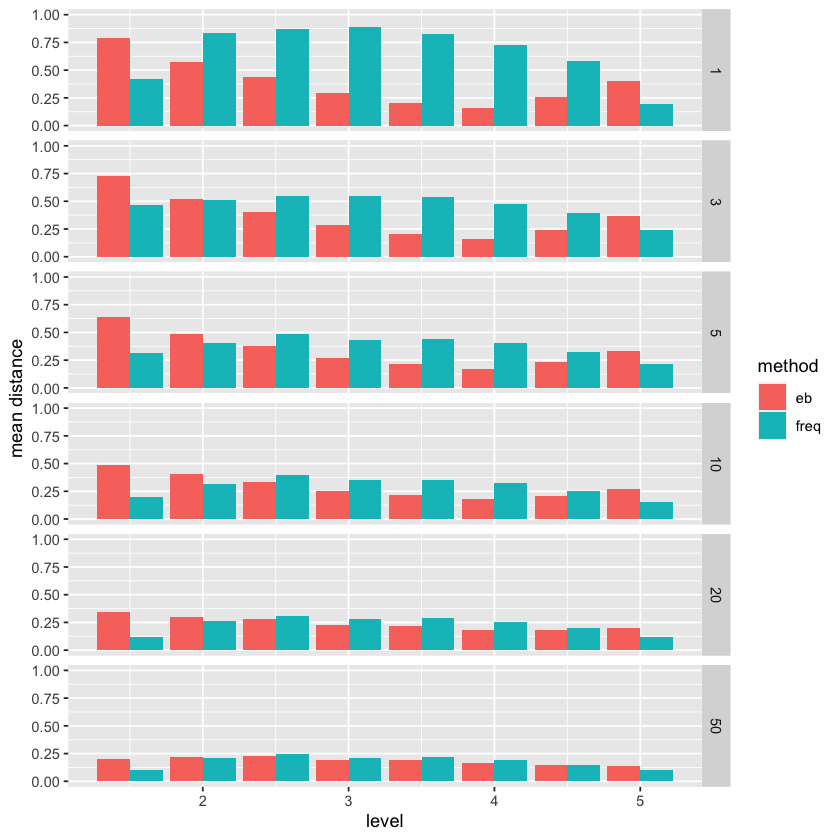

In [59]:
# Plotting averages by buckets of 0.5

ggplot(filter(avg_df, method %in% c('eb', 'freq'))) + 
    geom_bar(aes(x=level,y=mean_dist,fill=method), position='dodge', stat='identity') +
    facet_grid(rows = vars(num_train)) +
    scale_y_continuous(name="mean distance", limits=c(0, 1))

In [60]:
write.csv(x=avg_df, file="amazonfig3.csv")

#### Step 3.3: Train-validate-test split to see how some prior mixture does

In [28]:
# meta-comment - is this subsection even needed anymore? We're basically using it to assess the proper choice of hyperparameter,
# which is basically a positive statement that we don't even use in the subsequent subsections.

In [29]:
set.seed(1729)

in.val = sample(unique(df.test$item), size = 0.5*length(unique(df.test$item)))

df.val = filter(df.test, item %in% in.val)
df.test_final = filter(df.test, !(item %in% in.val))

In [30]:
#split val, test set in half

df.val_learn = group_by(df.val, item) %>% 
  arrange(timestamp, .by_group = TRUE) %>%
  slice_head(n=50)
df.val_eval = group_by(df.val, item) %>% 
  arrange(timestamp, .by_group = TRUE) %>%
  slice_tail(n=50)

df.test_final_learn = group_by(df.test_final, item) %>% 
  arrange(timestamp, .by_group = TRUE) %>%
  slice_head(n=50)
df.test_final_eval = group_by(df.test_final, item) %>% 
  arrange(timestamp, .by_group = TRUE) %>%
  slice_tail(n=50)

df.val_eval <- dcast(setDT(df.val_eval), item ~ rating, fun.aggregate = length) %>% arrange(item)
colnames(df.val_eval) <- c("item", "n1", "n2", "n3", "n4", "n5")
df.val_eval$n = df.val_eval$"n1" + df.val_eval$"n2" + df.val_eval$"n3" + df.val_eval$"n4" + df.val_eval$"n5"
df.val_eval <- transmute(df.val_eval, item=item, n1 = n1 / n, n2 = n2 / n, n3 = n3 / n, n4 = n4 / n, n5 = n5 / n)

df.test_final_eval <- dcast(setDT(df.test_final_eval), item ~ rating, fun.aggregate = length) %>% arrange(item)
colnames(df.test_final_eval) <- c("item", "n1", "n2", "n3", "n4", "n5")
df.test_final_eval$n = df.test_final_eval$"n1" + df.test_final_eval$"n2" + df.test_final_eval$"n3" + df.test_final_eval$"n4" + df.test_final_eval$"n5"
df.test_final_eval <- transmute(df.test_final_eval, item=item, n1 = n1 / n, n2 = n2 / n, n3 = n3 / n, n4 = n4 / n, n5 = n5 / n)

num_val_products = nrow(df.val_eval)
num_final_test_products = nrow(df.test_final_eval)

df.val_eval <- mutate(df.val_eval, avg = 1*n1 + 2*n2 + 3*n3 + 4*n4 + 5*n5)
df.test_final_eval <- mutate(df.test_final_eval, avg = 1*n1 + 2*n2 + 3*n3 + 4*n4 + 5*n5)

print(head(df.val_eval))

         item   n1   n2   n3   n4   n5  avg
1: 9867299434 0.10 0.12 0.12 0.24 0.42 3.76
2: B00000I1BY 0.00 0.02 0.06 0.16 0.76 4.66
3: B00000J2W7 0.00 0.00 0.02 0.22 0.76 4.74
4: B00000K2X5 0.04 0.02 0.04 0.24 0.66 4.46
5: B00001IVLY 0.02 0.00 0.02 0.08 0.88 4.80
6: B0000296O5 0.16 0.04 0.08 0.20 0.52 3.88


In [31]:
items = unique(df.test_learn$item)

mses_b = data.frame(matrix(ncol=3,nrow=0))

weights = 0:10 / 10

for (i in c(1:11)) {
    
  # convert validation into a data table
  df.test_learn_subset <- dcast(setDT(df.val_learn), item ~ rating, fun.aggregate = length, drop=FALSE) %>% arrange(item)
  
  # adding missing columns
  for (j in setdiff(c("item", "1", "2", "3", "4", "5"), colnames(df.test_learn_subset))) {
    df.test_learn_subset[[j]] <- rep(0, num_val_products)
  }
    
  df.test_learn_subset <- df.test_learn_subset[,c("item", "1", "2", "3", "4", "5")]
  
  colnames(df.test_learn_subset) <- c("item", "n1", "n2", "n3", "n4", "n5")
  df.test_learn_subset$n = df.test_learn_subset$"n1" + df.test_learn_subset$"n2" + df.test_learn_subset$"n3" + df.test_learn_subset$"n4" + df.test_learn_subset$"n5"
  
  adj_alphas = weights[i] * alphas + (1 - weights[i]) * c(0,0,0,0,0)
    
  df.test_learn_b <- mutate(df.test_learn_subset, item=item, b1 = n1 + adj_alphas[1], b2 = n2 + adj_alphas[2], b3 = n3 + adj_alphas[3],
         b4 = n4 + adj_alphas[4], b5 = n5 + adj_alphas[5], b = n + sum(adj_alphas))
  
  if (MAP_EST) {
      df.test_learn_b <- transmute(df.test_learn_b, item=item, b1 = (b1-1) / (b-5), b2 = (b2-1) / (b-5), b3 = (b3-1) / (b-5), b4 = (b4-1) / (b-5), b5 = b5 / b)
  } else {
      df.test_learn_b <- transmute(df.test_learn_b, item=item, b1 = b1 / b, b2 = b2 / b, b3 = b3 / b, b4 = b4 / b, b5 = b5 / b)
  }
    
  # print(rowSums((select(df.test_learn_b, c(b1,b2,b3,b4,b5)) - select(df.val_eval, c(n1,n2,n3,n4,n5)))^2))
  dists = rowSums((select(df.test_learn_b, c(b1,b2,b3,b4,b5)) - select(df.val_eval, c(n1,n2,n3,n4,n5)))^2)
  mse_b = mean(dists)  
  max_diff_b = max(dists)
  to_add <- c(weights[i], mse_b, max_diff_b)
    
  mses_b <- rbind(mses_b, to_add)
    
}

colnames(mses_b) <- c('weight on prior', 'mean dist', 'max dist')
mses_b

weight on prior,mean dist,max dist
<dbl>,<dbl>,<dbl>
0.0,0.04097649,0.3064000
0.1,0.03964379,0.2963712
0.2,0.03853498,0.2994083
0.3,0.03761773,0.3029486
0.4,0.03686483,0.3063798
0.5,0.03625330,0.3097033
0.6,0.03576363,0.3129210
0.7,0.03537921,0.3160356
0.8,0.03508586,0.3190498


The value that minimizes the maximum distance between a predicted distribution and the true distribution for a user is $\eta = 0.1$. Let's see how this does when we stratify across time and average rating quartiles:

In [32]:
PRIOR_WEIGHT = 0.1

In [33]:
alphas_mix = PRIOR_WEIGHT * alphas + (1 - PRIOR_WEIGHT)*c(0,0,0,0,0)

In [34]:
test_learn_agg <- dcast(setDT(df.test_final), item ~ rating, fun.aggregate = length)
colnames(test_learn_agg) <- c('item', 'n1', 'n2', 'n3', 'n4', 'n5')
test_learn_agg <- test_learn_agg %>% mutate(n = n1 + n2 + n3 + n4 + n5)
test_learn_agg <- transmute(test_learn_agg, item=item, n1 = n1 / n, n2 = n2 / n, n3 = n3 / n, n4 = n4 / n, n5 = n5 / n)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



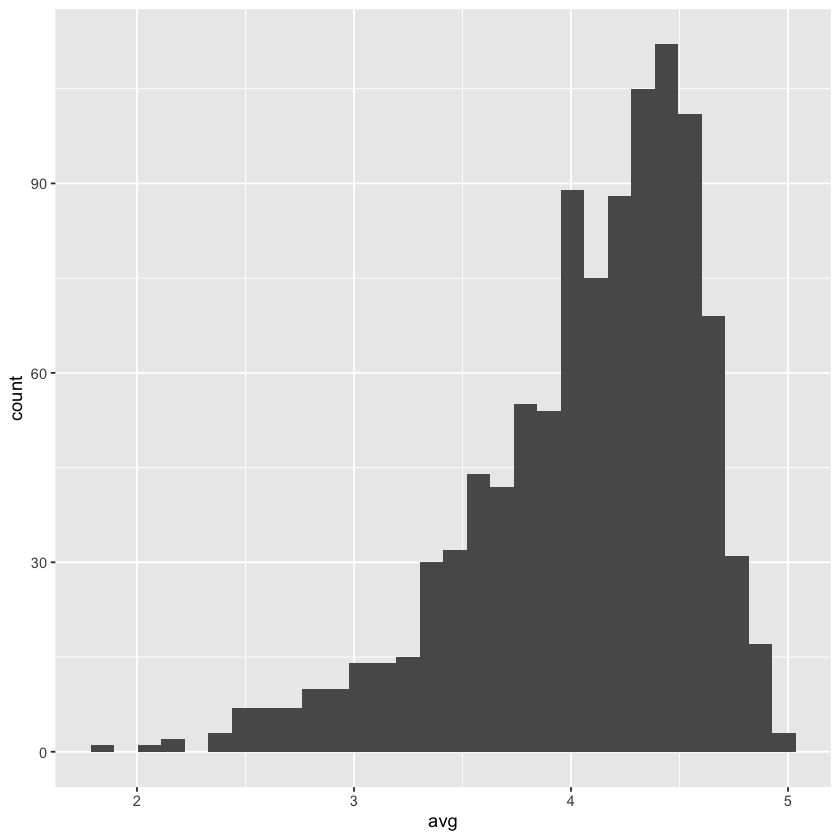

In [35]:
test_subset = test_learn_agg %>% mutate(avg = (n1+2*n2+3*n3+4*n4+5*n5))
ggplot(test_subset, aes(x=avg)) +
    geom_histogram()

In [36]:
set.seed(1729)

num_prods = 20

test_subset_1 <- test_subset %>% filter(!duplicated(item)) %>% filter(avg <= 2) 
test_subset_1 <- test_subset_1 %>% sample_n(min(num_prods, nrow(test_subset_1))) 
test_subset_2 <- test_subset %>% filter(!duplicated(item)) %>% filter(avg <= 3, avg > 2) 
test_subset_2 <- test_subset_2 %>% sample_n(min(num_prods, nrow(test_subset_2)))
test_subset_3 <- test_subset %>% filter(!duplicated(item)) %>% filter(avg <= 4, avg > 3) 
test_subset_3 <- test_subset_3 %>% sample_n(min(num_prods, nrow(test_subset_3)))
test_subset_4 <- test_subset %>% filter(!duplicated(item)) %>% filter(avg > 4) 
test_subset_4 <- test_subset_4 %>% sample_n(min(num_prods, nrow(test_subset_4)))

# this is the list of items, along with their average score, that we will test

test_subset <- rbind(test_subset_1, test_subset_2, test_subset_3, test_subset_4)
print(nrow(test_subset))

[1] 61


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



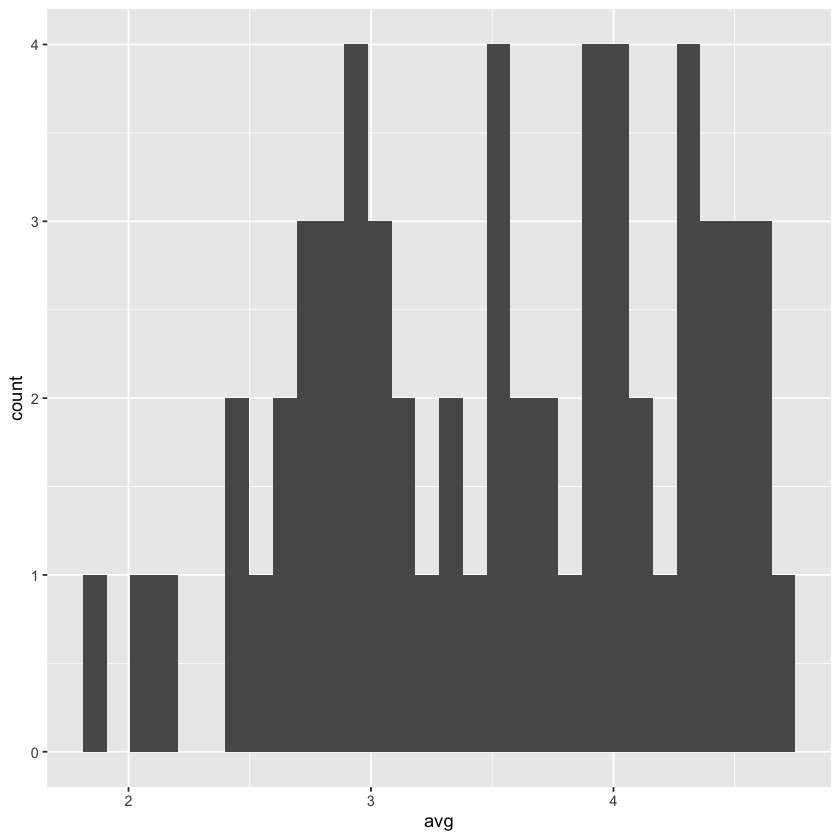

In [37]:
ggplot(test_subset, aes(x=avg)) +
    geom_histogram()

In [38]:
results_df = data.frame(matrix(ncol=5,nrow=0))

for (i in c(1, 3, 5, 10, 50)) {
  df.test_learn_subset = group_by(df.test_final_learn, item) %>%
    filter(item %in% test_subset$item) %>%
    arrange(timestamp, .by_group = TRUE) %>%
    slice_head(n=i)
    
  df.test_learn_subset <- dcast(setDT(df.test_learn_subset), item ~ rating, fun.aggregate = length, drop=FALSE) %>% arrange(item)
  
  # adding missing columns
  for (j in setdiff(c("item", "1", "2", "3", "4", "5"), colnames(df.test_learn_subset))) {
    df.test_learn_subset[[j]] <- rep(0, num_eval_products)
  }
  df.test_learn_subset <- df.test_learn_subset[,c("item", "1", "2", "3", "4", "5")]
    
  colnames(df.test_learn_subset) <- c("item", "n1", "n2", "n3", "n4", "n5")
  df.test_learn_subset$n = df.test_learn_subset$"n1" + df.test_learn_subset$"n2" + df.test_learn_subset$"n3" + df.test_learn_subset$"n4" + df.test_learn_subset$"n5"
    
  df.test_learn_f <- transmute(df.test_learn_subset, item=item, n1 = n1 / n, n2 = n2 / n, n3 = n3 / n, n4 = n4 / n, n5 = n5 / n)
  df.test_learn_b <- mutate(df.test_learn_subset, item=item, b1 = n1 + alphas[1], b2 = n2 + alphas[2], b3 = n3 + alphas[3],
         b4 = n4 + alphas[4], b5 = n5 + alphas[5], b = n + sum(alphas))
    
  if (MAP_EST) {
      df.test_learn_b <- transmute(df.test_learn_b, item=item, b1 = (b1-1) / (b-5), b2 = (b2-1) / (b-5), b3 = (b3-1) / (b-5), b4 = (b4-1) / (b-5), b5 = (b5-1) / (b-5))
  } else {
      df.test_learn_b <- transmute(df.test_learn_b, item=item, b1 = b1 / b, b2 = b2 / b, b3 = b3 / b, b4 = b4 / b, b5 = b5 / b)
  }
  
  df.test_learn_p <- mutate(df.test_learn_subset, item=item, b1 = n1 + alphas_mix[1], b2 = n2 + alphas_mix[2], b3 = n3 + alphas_mix[3],
         b4 = n4 + alphas_mix[4], b5 = n5 + alphas_mix[5], b = n + sum(alphas_mix))
    
  if (MAP_EST) {
      df.test_learn_p <- transmute(df.test_learn_p, item=item, b1 = (b1-1) / (b-5), b2 = (b2-1) / (b-5), b3 = (b3-1) / (b-5), b4 = (b4-1) / (b-5), b5 = (b5-1) / (b-5))
  } else {
      df.test_learn_p <- transmute(df.test_learn_p, item=item, b1 = b1 / b, b2 = b2 / b, b3 = b3 / b, b4 = b4 / b, b5 = b5 / b)
  }
    
  for (id in unique(test_subset$item)) {
      dist_b = filter(df.test_learn_b, item==id) %>% select(c(b1, b2, b3, b4, b5))
      dist_f = filter(df.test_learn_f, item==id) %>% select(c(n1, n2, n3, n4, n5))
      dist_p = filter(df.test_learn_p, item==id) %>% select(c(b1, b2, b3, b4, b5))
      av = filter(test_subset, item==id)$avg
      dist_eval = filter(df.test_final_eval, item==id) %>% select(c(n1, n2, n3, n4, n5))
      
      to_add = c(id, sqrt(sum((dist_eval-dist_b)^2)), drop(av), i, 'eb')
      
      results_df <- rbind(results_df, to_add)
      
      to_add = c(id, sqrt(sum((dist_eval-dist_f)^2)), drop(av), i, 'freq')
      
      results_df <- rbind(results_df, to_add)
      
      to_add = c(id, sqrt(sum((dist_eval-alphas_b)^2)), drop(av), i, 'baseline')
      
      results_df <- rbind(results_df, to_add)
      
      to_add = c(id, sqrt(sum((dist_eval-dist_p)^2)), drop(av), i, 'mixed')
      
      results_df <- rbind(results_df, to_add)
      
  }

}

colnames(results_df) <- c('item', 'dist', 'avg', 'num_train', 'method')

In [39]:
results_df$dist <- as.numeric(results_df$dist)
results_df$avg <- as.numeric(results_df$avg)
results_df$num_train <- as.numeric(results_df$num_train)

Warning message:
“Removed 19 rows containing missing values (geom_point).”


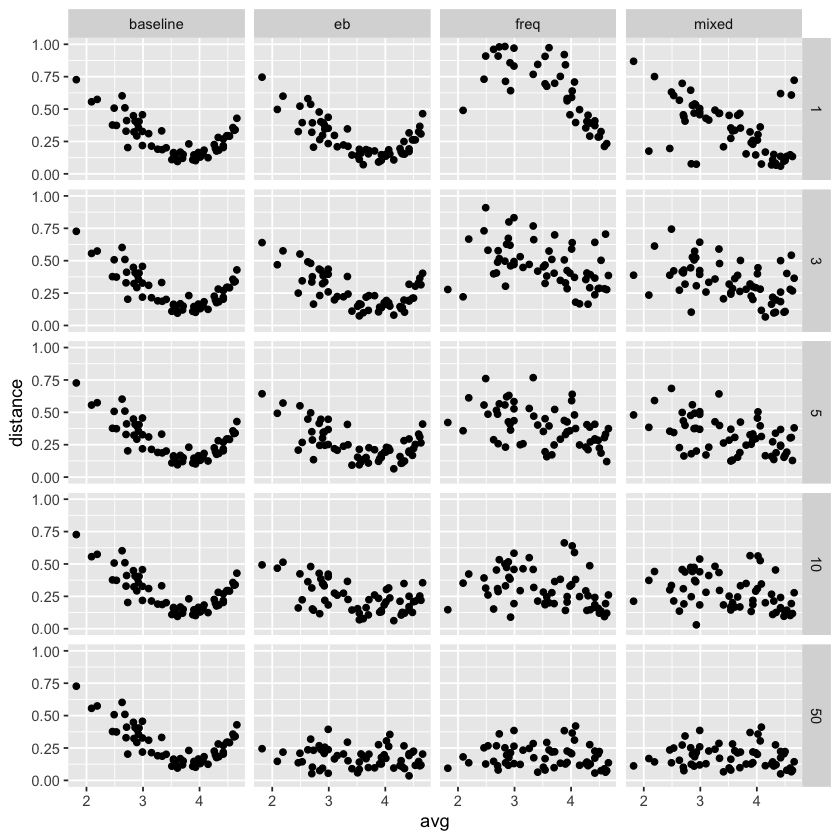

In [40]:
ggplot(results_df) + 
    geom_point(aes(x=avg, y=dist)) +
    facet_grid(rows = vars(num_train), cols=vars(method)) +
    scale_y_continuous(name="distance", limits=c(0, 1))

In [41]:
avg_df <- results_df %>% 
           mutate(level=floor(avg*2)/2) %>%
#           mutate(level=floor(avg)) %>%
          group_by(level, method, num_train) %>%
          summarize(mean_dist=mean(dist), std = sd(dist), n=dplyr::n())

`summarise()` has grouped output by 'level', 'method'. You can override using the `.groups` argument.



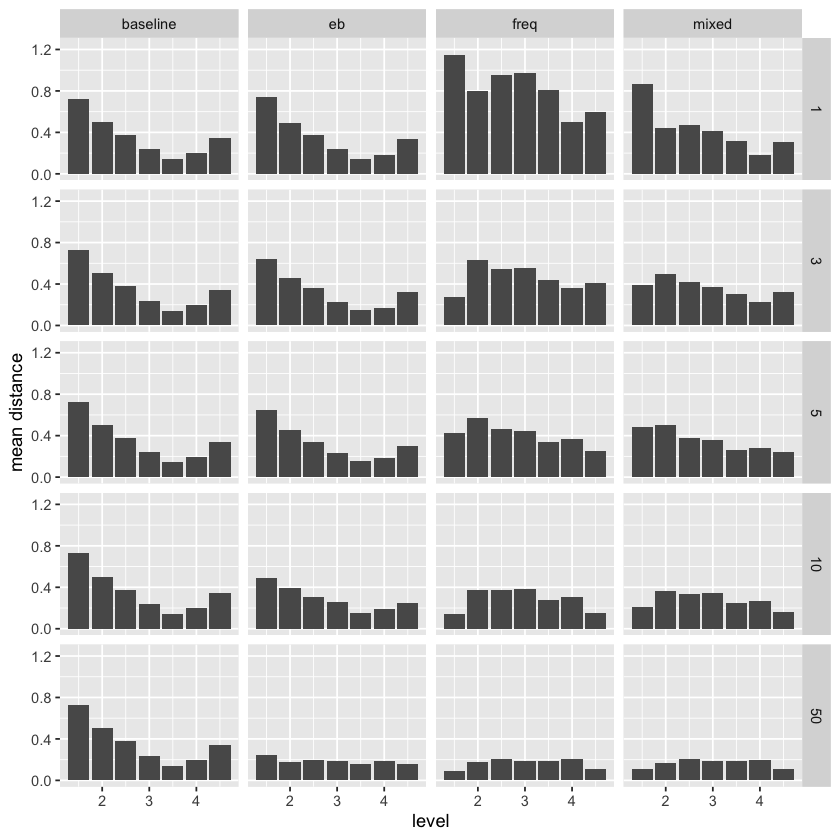

In [42]:
# Plotting averages by buckets of 0.5

ggplot(avg_df) + 
    geom_bar(aes(x=level,y=mean_dist),stat='identity') +
    facet_grid(rows = vars(num_train), cols=vars(method)) +
    scale_y_continuous(name="mean distance", limits=c(0, 1.25))

### 3.5: Plotting all data points and all mixture weights

In [61]:
# meta-comment - why even split test into validation and test here? For what purpose are we using validation?

In [62]:
USE_VAL_SET = TRUE

In [63]:
set.seed(1729)

in.val = sample(unique(df.test$item), size = 0.5*length(unique(df.test$item)))

df.val = filter(df.test, item %in% in.val)
df.test_final = filter(df.test, !(item %in% in.val))

In [64]:
#split val, test set in half

df.val_learn = group_by(df.val, item) %>% 
  arrange(timestamp, .by_group = TRUE) %>%
  slice_head(n=50)
df.val_eval = group_by(df.val, item) %>% 
  arrange(timestamp, .by_group = TRUE) %>%
  slice_tail(n=50)

df.test_final_learn = group_by(df.test_final, item) %>% 
  arrange(timestamp, .by_group = TRUE) %>%
  slice_head(n=50)
df.test_final_eval = group_by(df.test_final, item) %>% 
  arrange(timestamp, .by_group = TRUE) %>%
  slice_tail(n=50)

df.val_eval <- dcast(setDT(df.val_eval), item ~ rating, fun.aggregate = length) %>% arrange(item)
colnames(df.val_eval) <- c("item", "n1", "n2", "n3", "n4", "n5")
df.val_eval$n = df.val_eval$"n1" + df.val_eval$"n2" + df.val_eval$"n3" + df.val_eval$"n4" + df.val_eval$"n5"
df.val_eval <- transmute(df.val_eval, item=item, n1 = n1 / n, n2 = n2 / n, n3 = n3 / n, n4 = n4 / n, n5 = n5 / n)

df.test_final_eval <- dcast(setDT(df.test_final_eval), item ~ rating, fun.aggregate = length) %>% arrange(item)
colnames(df.test_final_eval) <- c("item", "n1", "n2", "n3", "n4", "n5")
df.test_final_eval$n = df.test_final_eval$"n1" + df.test_final_eval$"n2" + df.test_final_eval$"n3" + df.test_final_eval$"n4" + df.test_final_eval$"n5"
df.test_final_eval <- transmute(df.test_final_eval, item=item, n1 = n1 / n, n2 = n2 / n, n3 = n3 / n, n4 = n4 / n, n5 = n5 / n)

num_val_products = nrow(df.val_eval)
num_final_test_products = nrow(df.test_final_eval)

df.val_eval <- mutate(df.val_eval, avg = 1*n1 + 2*n2 + 3*n3 + 4*n4 + 5*n5)
df.test_final_eval <- mutate(df.test_final_eval, avg = 1*n1 + 2*n2 + 3*n3 + 4*n4 + 5*n5)

In [65]:
# comment out this line if you want to use validation set instead of test set

if (!USE_VAL_SET) {
    df.val_learn <- df.test_learn
    df.val_eval <- df.test_eval
    df.val_eval <- mutate(df.val_eval, avg = (n1 + 2*n2 + 3*n3 + 4*n4 + 5*n5)/(n1 + n2 + n3 + n4 + n5))
}

In [66]:
dirich <- function(x) {
    rdirichlet(1000, x)
}

botquantile <- function(x) {
    quantile(x, 0.025)
}

topquantile <- function(x) {
    quantile(x, 0.975)
}

ci_dirich <- function(x) {
    data <- rdirichlet(1000, x[1:5])
    value_ci <- data %*% c(1,2,3,4,5)
    c(quantile(value_ci, 0.025), quantile(value_ci, 0.975))
}

In [67]:
items = unique(df.test_learn$item)

weights = 0:10 / 10

val_results_df <- data.frame(matrix(ncol=13,nrow=0))

for (i in c(1:11)) {

  for (k in c(1,3,5,10,20,50)) {
  
    df.test_learn_subset = group_by(df.val_learn, item) %>%
      arrange(timestamp, .by_group = TRUE) %>%
      slice_head(n=k)
  
      # convert validation into a data table
    df.test_learn_subset <- dcast(setDT(df.test_learn_subset), item ~ rating, fun.aggregate = length, drop=FALSE) %>% arrange(item)

      # adding missing columns
    for (j in setdiff(c("item", "1", "2", "3", "4", "5"), colnames(df.test_learn_subset))) {
      df.test_learn_subset[[j]] <- rep(0, num_val_products)
      }

    df.test_learn_subset <- df.test_learn_subset[,c("item", "1", "2", "3", "4", "5")]

    colnames(df.test_learn_subset) <- c("item", "n1", "n2", "n3", "n4", "n5")
    df.test_learn_subset$n = df.test_learn_subset$"n1" + df.test_learn_subset$"n2" + df.test_learn_subset$"n3" + df.test_learn_subset$"n4" + df.test_learn_subset$"n5"

    if (MAP_EST) {
        adj_alphas = weights[i] * alphas + (1 - weights[i]) * c(1,1,1,1,1)
    } else {
        adj_alphas = weights[i] * alphas + (1-weights[i]) * c(1e-5, 1e-5, 1e-5, 1e-5, 1e-5)
    }
    
    df.test_learn_b <- mutate(df.test_learn_subset, item=item, b1 = n1 + adj_alphas[1], b2 = n2 + adj_alphas[2], b3 = n3 + adj_alphas[3],
             b4 = n4 + adj_alphas[4], b5 = n5 + adj_alphas[5], b = n + sum(adj_alphas))
      
    # generating confidence interval endpoints, this may be very computationally intensive
      
    ci_data <- tibble(select(df.test_learn_b, c(b1, b2, b3, b4, b5)), select(df.val_eval, c(n1, n2, n3, n4, n5)))
    ci_data <- apply(ci_data, 1, ci_dirich) 
    ci_data <- t(ci_data)
      
    if (MAP_EST) {
        df.test_learn_b <- transmute(df.test_learn_b, item=item, b1 = (b1-1) / (b-5), b2 = (b2-1) / (b-5), b3 = (b3-1) / (b-5), b4 = (b4-1) / (b-5), b5 = (b5-1) / (b-5))
    } else {
        df.test_learn_b <- transmute(df.test_learn_b, item=item, b1 = b1 / b, b2 = b2 / b, b3 = b3 / b, b4 = b4 / b, b5 = b5 / b)
    }
      
    df.test_learn_b <- transmute(df.test_learn_b, item=item, avg = (b1+b2*2+b3*3+b4*4+b5*5), b1 = b1, b2 = b2, b3 = b3, b4 = b4, b5 = b5)

    dists = rowSums((select(df.test_learn_b, c(b1,b2,b3,b4,b5)) - select(df.val_eval, c(n1,n2,n3,n4,n5)))^2)
    
    eb_est <- df.test_learn_b$avg
      

    to_add = tibble(df.test_learn_b$item, df.val_eval$avg, dists, weights[i], k, eb_est, 
                    ci_data[,1], ci_data[,2], 
                    df.test_learn_b$b1, df.test_learn_b$b2, df.test_learn_b$b3, df.test_learn_b$b4, df.test_learn_b$b5)

    val_results_df <- rbind(val_results_df, to_add)
    
  }
    
}

colnames(val_results_df) <- c('item', 'avg', 'distance', 'eta', 'num_train', 'est', 'value_0.025', 'value_0.975', 'b1', 'b2', 'b3', 'b4', 'b5')
head(val_results_df)

item,avg,distance,eta,num_train,est,value_0.025,value_0.975,b1,b2,b3,b4,b5
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
9867299434,3.76,0.432742,0,1,4.99990,5,5,9.9995e-06,9.9995e-06,9.9995e-06,9.9995e-06,9.9996e-01
B00000F1GM,4.82,1.445514,0,1,3.99995,4,4,9.9995e-06,9.9995e-06,9.9995e-06,9.9996e-01,9.9995e-06
B00000J9J9,4.68,0.033584,0,1,4.99990,5,5,9.9995e-06,9.9995e-06,9.9995e-06,9.9995e-06,9.9996e-01
B00001KUII,4.46,0.074376,0,1,4.99990,5,5,9.9995e-06,9.9995e-06,9.9995e-06,9.9995e-06,9.9996e-01
B00001ZWP8,4.72,0.077578,0,1,4.99990,5,5,9.9995e-06,9.9995e-06,9.9995e-06,9.9995e-06,9.9996e-01
B00002SUOV,4.36,0.235160,0,1,4.99990,5,5,9.9995e-06,9.9995e-06,9.9995e-06,9.9995e-06,9.9996e-01


Warning message:
“Removed 1 rows containing missing values (geom_hex).”


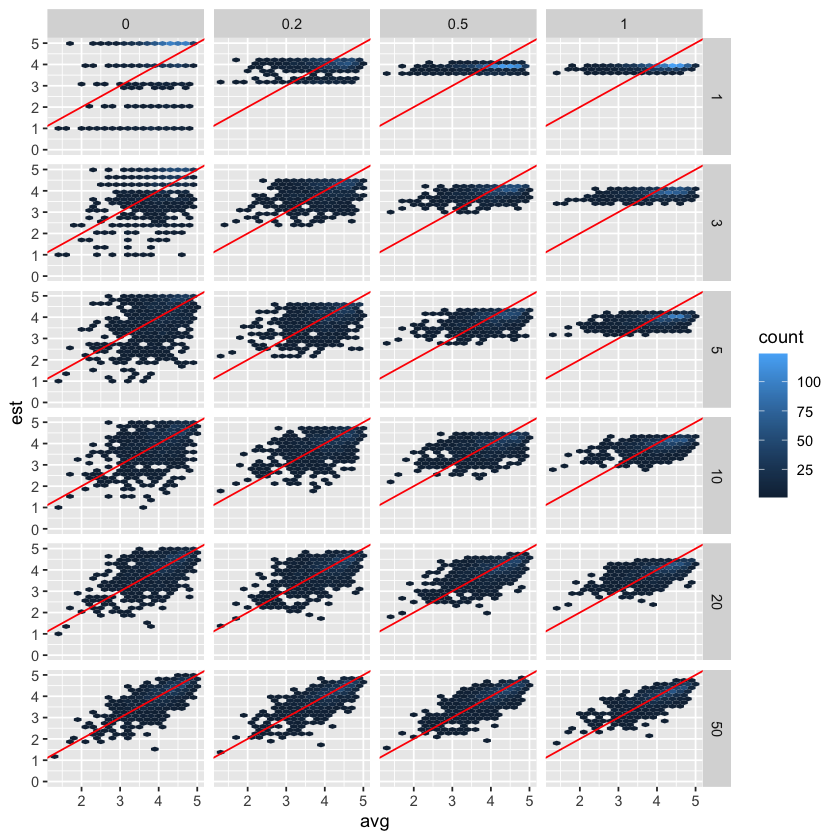

In [72]:
ggplot(filter(val_results_df, eta %in% c(0,0.2,0.5,1), num_train %in% c(1,3,5,10,20,50))) + 
    geom_hex(aes(x=avg, y=est), binwidth= c(0.2,0.2)) +
    geom_abline(color='red')+
    facet_grid(rows = vars(num_train), cols=vars(eta)) +
    scale_y_continuous(name="est", limits=c(0, 5))

In [52]:
grouped_val_results_df <- mutate(val_results_df, avg = round(avg,1)) %>%
                          group_by(avg, num_train, eta) %>%
                          summarize(est = mean(est), value_0.025 = mean(value_0.025), value_0.975 = mean(value_0.975))

`summarise()` has grouped output by 'avg', 'num_train'. You can override using the `.groups` argument.



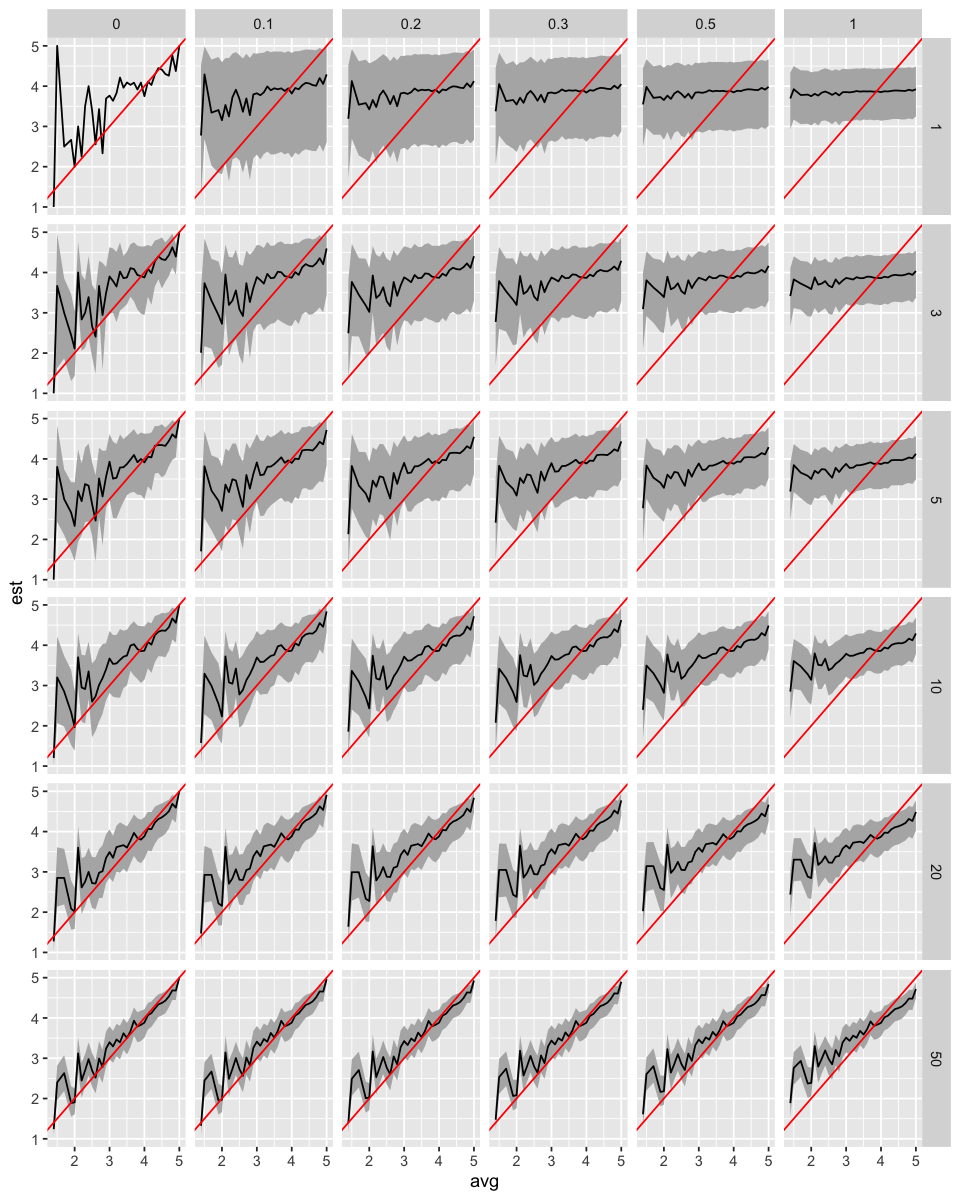

In [53]:
ggplot(filter(grouped_val_results_df, eta %in% c(0,0.1,0.2,0.3,0.5,1))) + 
    geom_ribbon(aes(x=avg,ymin=value_0.025, ymax=value_0.975), fill='grey70') +
    geom_line(aes(x=avg,y=est)) +
    geom_abline(color='red')+
    facet_grid(rows = vars(num_train), cols=vars(eta))
#     scale_y_continuous(name="mean distance", limits=c(0, 1.25))

### 3.6 Ordinal analysis

#### 3.6a Ramesh's suggestion - discretize by .1 intervals and look at Kendall-Tau

In [53]:
ord_results_df <- val_results_df

In [54]:
ord_results_df <- mutate(ord_results_df, avg=round(avg,1), est=round(est,1))

In [55]:
head(ord_results_df)

item,avg,distance,eta,num_train,est,value_0.025,value_0.975,b1,b2,b3,b4,b5
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
9867299434,3.8,0.432742,0,1,5,5,5,9.9995e-06,9.9995e-06,9.9995e-06,9.9995e-06,9.9996e-01
B00000I1BY,4.7,0.087176,0,1,5,5,5,9.9995e-06,9.9995e-06,9.9995e-06,9.9995e-06,9.9996e-01
B00000J2W7,4.7,1.186322,0,1,4,4,4,9.9995e-06,9.9995e-06,9.9995e-06,9.9996e-01,9.9995e-06
B00000K2X5,4.5,1.016724,0,1,4,4,4,9.9995e-06,9.9995e-06,9.9995e-06,9.9996e-01,9.9995e-06
B00001IVLY,4.8,1.621508,0,1,4,4,4,9.9995e-06,9.9995e-06,9.9995e-06,9.9996e-01,9.9995e-06
B0000296O5,3.9,0.303952,0,1,5,5,5,9.9995e-06,9.9995e-06,9.9995e-06,9.9995e-06,9.9996e-01


In [56]:
kendall_tau_df = data.frame(matrix(ncol=5, nrow=0))

for (i in 0:10/10) {
    for (k in c(1,3,5,10,20,50)) {
        ord_results_subset <- filter(ord_results_df, eta==i, num_train==k)
        num_ties_avg = 0
        num_ties_est = 0
        for (ind_1 in 1:nrow(ord_results_subset)) {
            for (ind_2 in ind_1:nrow(ord_results_subset)) {
                if (ord_results_subset$avg[ind_1] == ord_results_subset$avg[ind_2]) {
                    num_ties_avg = num_ties_avg + 1
                }
                if (ord_results_subset$est[ind_1] == ord_results_subset$est[ind_2]) {
                    num_ties_est = num_ties_est + 1
                }
            }
        }
        kendall_tau_df <- rbind(kendall_tau_df, c(i, k, KendallTauB(ord_results_subset$avg, ord_results_subset$est), num_ties_avg, num_ties_est))
    }
}

colnames(kendall_tau_df) <- c('eta', 'num_train', 'tau_a', 'num_ties_avg', 'num_ties_est')

In [57]:
dcast(setDT(kendall_tau_df), eta~num_train, value.var='tau_a')

eta,1,3,5,10,20,50
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.0,0.1831222,0.2537590,0.2926884,0.3666004,0.4703463,0.5954270
0.1,0.1831222,0.2537590,0.2926884,0.3700883,0.4685011,0.5945055
0.2,0.1831222,0.2537590,0.2926884,0.3685164,0.4713125,0.5974577
0.3,0.1831222,0.2537590,0.2926884,0.3720328,0.4710150,0.5972323
0.4,0.1831222,0.2537590,0.2932594,0.3709948,0.4742231,0.5977205
0.5,0.1831222,0.2541132,0.2979172,0.3704941,0.4743618,0.5978898
0.6,0.1831222,0.2522522,0.3015682,0.3752740,0.4744438,0.5947644
0.7,0.1657256,0.2525650,0.2950366,0.3737505,0.4712254,0.5962173
0.8,0.1686789,0.2570064,0.2952098,0.3720233,0.4731222,0.5964369


In [58]:
dcast(setDT(kendall_tau_df), eta~num_train, value.var='num_ties_avg')

eta,1,3,5,10,20,50
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.0,31744,31744,31744,31744,31744,31744
0.1,31744,31744,31744,31744,31744,31744
0.2,31744,31744,31744,31744,31744,31744
0.3,31744,31744,31744,31744,31744,31744
0.4,31744,31744,31744,31744,31744,31744
0.5,31744,31744,31744,31744,31744,31744
0.6,31744,31744,31744,31744,31744,31744
0.7,31744,31744,31744,31744,31744,31744
0.8,31744,31744,31744,31744,31744,31744


In [59]:
dcast(setDT(kendall_tau_df), eta~num_train, value.var='num_ties_est')

eta,1,3,5,10,20,50
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.0,222597,85884,51015,26277,28082,30707
0.1,222597,85884,51015,34608,31671,32019
0.2,222597,85884,51015,38877,33697,32711
0.3,222597,85884,51015,42952,36204,34024
0.4,222597,85884,54182,45524,38611,35009
0.5,222597,86493,65035,47919,39155,36001
0.6,222597,104896,86375,51446,41263,36699
0.7,333576,105525,81120,55702,43015,37519
0.8,340225,108797,81355,58256,46840,37765


In [60]:
eb_freq_ord_comp <- data.frame(matrix(ncol=2, nrow=0))
for (i in c(1,3,5,10,20,50)) {
    kta <- KendallTauB(filter(ord_results_df, eta==0, num_train==i)$est, 
                       filter(ord_results_df, eta==1, num_train==i)$est)
    
    eb_freq_ord_comp <- rbind(eb_freq_ord_comp, c(i,kta))
}



In [61]:
eb_freq_ord_comp

X1,X0.798239067620206
<dbl>,<dbl>
1,0.7982391
3,0.9208168
5,0.9446390
10,0.9610416
20,0.9727370
50,0.9784897


### 3.7 Generating confidence intervals for kendall-tau

In [62]:
TAU = 'A'

In [63]:
gen_data <- function(x) {
    temp <- rdirichlet(100, x)
    temp <- temp %*% c(1,2,3,4,5)
    temp
}

kendall_tau_ci <- function(x,y,tau) {
    data <- t(apply(x, 1, gen_data))
    
    kt <- function(k) {
        if (tau=='A') {
            KendallTauA(k, y)
        } else {
            KendallTauB(k, y)
        }
    }
    
    data <- apply(data, 2, kt)
    data
}

In [64]:
test <- rdirichlet(1000, c(1,2,3,4,5))

In [65]:
testfunc <- function(x) {
    temp <- rdirichlet(100, x)
    temp <- temp %*% c(1,2,3,4,5)
    temp
}

In [66]:
t(apply(test, 1, testfunc))

2.941537,2.005307,3.145078,3.929215,3.945224,4.604299,2.687409,3.988168,4.062675,3.815421,⋯,3.375922,2.821518,3.959914,3.818599,3.211438,2.526353,2.921444,3.703090,3.803418,3.998587
2.162947,2.539572,2.901858,4.687324,2.586456,4.192340,3.388835,4.900934,3.137981,3.433308,⋯,4.919173,3.293738,4.999961,3.995390,1.150070,4.281836,4.213158,3.658588,4.999954,4.206542
4.365616,1.833317,4.266455,1.348327,2.481309,4.374820,1.606815,3.046682,3.811950,2.122590,⋯,2.772244,4.785615,4.559653,3.431675,4.898185,3.782446,4.736670,3.463893,4.131980,4.611017
4.900094,4.745329,2.829775,3.446480,3.889314,3.302510,4.095307,3.530973,3.224394,4.009960,⋯,4.240855,4.800435,4.041279,4.835357,4.550296,1.362304,3.581620,4.485743,4.617741,4.494944
4.874898,4.059206,4.999632,4.997912,4.718210,4.959560,4.974943,3.871822,4.816405,4.996035,⋯,4.893224,4.085292,4.997668,4.042443,4.921102,4.974616,2.746683,4.698614,3.950956,4.838500
2.428299,3.804953,3.966852,3.933804,3.882235,4.512077,2.122525,2.775383,4.959566,2.871635,⋯,4.322566,4.034844,3.861371,3.331186,4.152717,1.218991,3.391293,2.607462,3.532055,4.808624
3.964223,4.762971,3.936855,2.639029,3.931953,3.962551,3.887010,4.331246,4.912510,3.981948,⋯,4.647098,4.002280,3.872359,4.840494,3.355751,4.960785,4.051308,4.136306,3.143036,4.743935
3.840654,2.287460,3.181656,2.506561,4.244099,4.150884,3.813682,3.816192,4.533597,4.180819,⋯,2.268546,2.969126,2.950889,4.863829,2.014623,4.753268,4.789454,2.817892,3.734022,3.600967
4.513814,3.530423,2.253449,3.074524,4.797318,2.429109,3.285383,1.638361,2.524737,4.162946,⋯,3.581826,3.522692,3.684556,4.583421,2.268515,3.861249,2.130058,3.430828,2.182226,2.913303
4.918870,3.335371,3.963467,4.091485,3.021615,4.712743,1.126798,3.654732,3.667329,4.475729,⋯,4.852183,3.196217,3.692395,1.666247,3.886994,4.891701,4.081560,4.856302,4.437998,3.366369
4.022511,1.342225,3.440392,3.919364,3.563689,4.648147,4.931102,3.058045,4.440553,4.185674,⋯,4.584004,1.956830,4.235536,4.058043,2.970598,4.626799,4.924526,4.045962,4.014679,4.893784


In [67]:
test_df <- filter(val_results_df, eta==0, num_train==3)

In [68]:
kendall_tau_ci(select(test_df, c(b1,b2,b3,b4,b5)), test_df$est, TAU)

[1] 0.6530900 0.6479395 0.6656020 0.6478615 0.6592475 0.6565905 0.6631234
  [8] 0.6507563 0.6593702 0.6621758 0.6595485 0.6572892 0.6553048 0.6600168
 [15] 0.6579060 0.6452045 0.6493962 0.6554125 0.6463825 0.6555798 0.6580249
 [22] 0.6529525 0.6623356 0.6602174 0.6694481 0.6452157 0.6481439 0.6460481
 [29] 0.6513583 0.6508455 0.6477389 0.6505111 0.6577016 0.6571145 0.6526404
 [36] 0.6514401 0.6532164 0.6689911 0.6477983 0.6702917 0.6616110 0.6483297
 [43] 0.6497753 0.6577202 0.6638517 0.6721163 0.6412655 0.6509012 0.6564828
 [50] 0.6555798 0.6487088 0.6584374 0.6637626 0.6442904 0.6504925 0.6601803
 [57] 0.6642605 0.6592104 0.6624248 0.6673226 0.6516259 0.6604553 0.6660740
 [64] 0.6613100 0.6625214 0.6620086 0.6559031 0.6464791 0.6525103 0.6601914
 [71] 0.6535285 0.6593479 0.6492253 0.6547325 0.6625511 0.6547065 0.6621907
 [78] 0.6397084 0.6586047 0.6522204 0.6589242 0.6580956 0.6493851 0.6574452
 [85] 0.6583594 0.6438147 0.6504925 0.6655723 0.6591026 0.6499536 0.6500057
 [92] 0.6628001 0.6535842 0.6510350 0.6475791 0.6519380 0.6597455 0.6493145
 [99] 0.6684931 0.6555129

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 6871 rows containing non-finite values (stat_bin).”


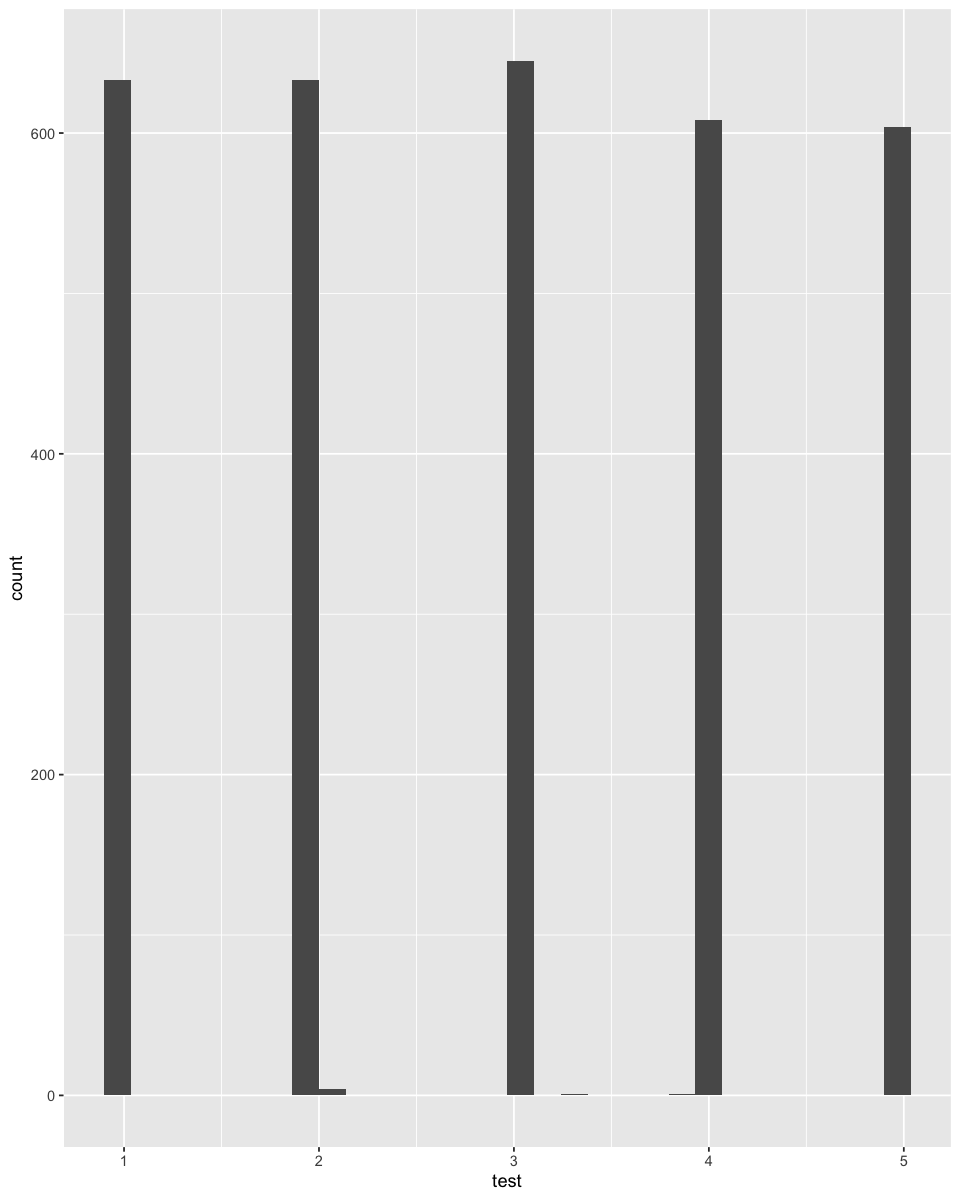

In [69]:
set.seed(1729)
test <- as.vector(rdirichlet(10000, c(1e-4,1e-4,1e-4,1e-4,1e-4)) %*% c(1,2,3,4,5))
ggplot() + aes(test) + geom_histogram()

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



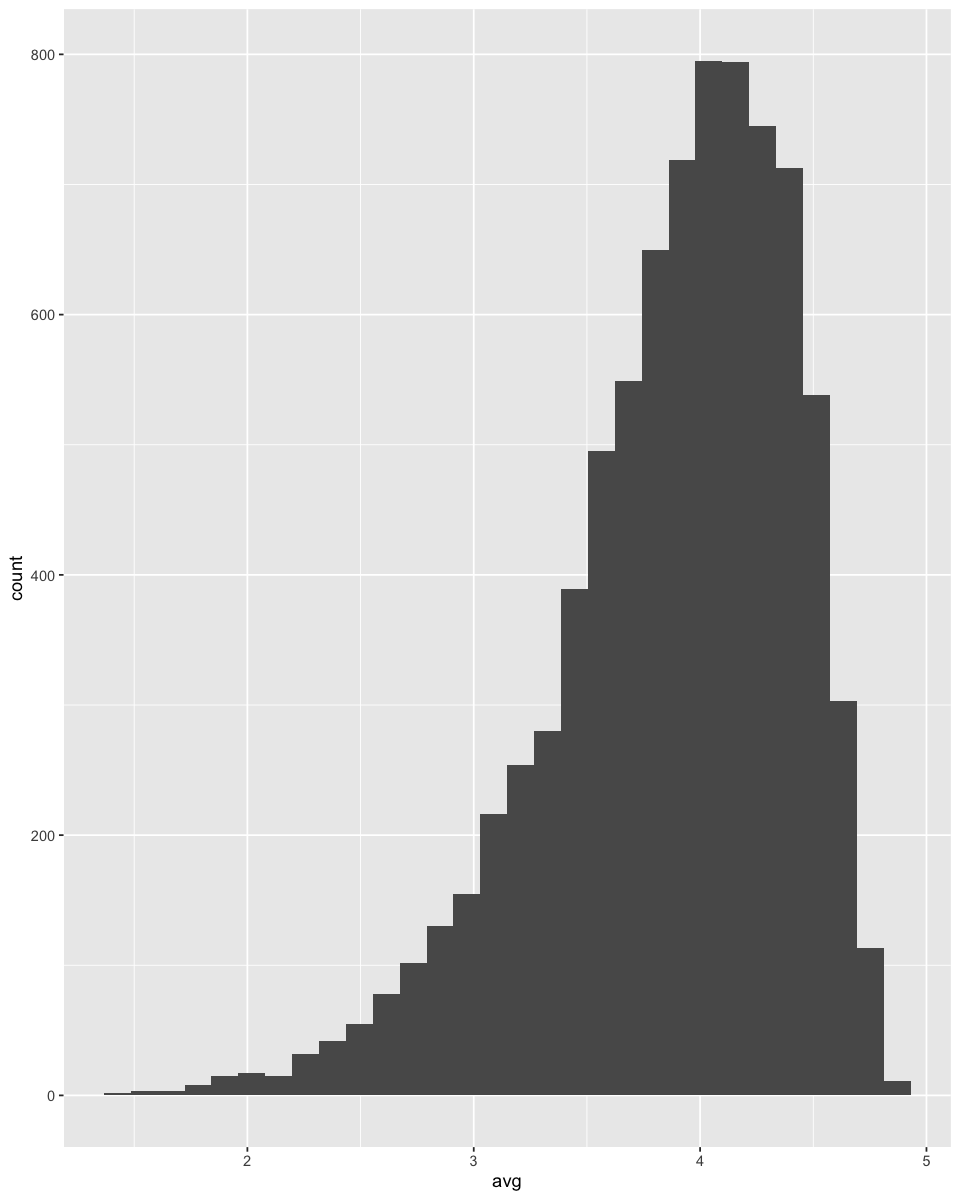

In [70]:
prior_df <- mutate(prior_df, avg = n1 + 2*n2 + 3*n3 + 4*n4 + 5*n5)
ggplot(prior_df) + geom_histogram(aes(x=avg))

#### Getting individual data

In [12]:
df.test_eval_copy$avg <- rowSums(data.frame(mapply(`*`,select(df.test_eval_copy, -item),c(1,2,3,4,5))))

In [13]:
df <- merge(select(df.test_learn_copy, -avg), select(df.test_eval_copy,c(item,avg)), by='item')

In [14]:
eb_est <- function(x) {
    v <- x + alphas
    v <- v/sum(v)
    v %*% c(1,2,3,4,5)
}

freq_est <- function(x) {
    v <- x/sum(x)
    v %*% c(1,2,3,4,5)
}

adjusted_freq_est <- function(x) {
    v <- x + 1
    v <- v/sum(v)
    v %*% c(1,2,3,4,5)
}

mixture_0.2_est <- function(x) {
    v <- 0.2 * alphas + 0.8
    v <- x + v
    v <- v/sum(v)
    v %*% c(1,2,3,4,5)
}

mixture_0.5_est <- function(x) {
    v <- 0.5 * alphas + 0.5
    v <- x + v
    v <- v/sum(v)
    v %*% c(1,2,3,4,5)
}

In [37]:
running_avg_df <- data.frame(matrix(ncol = 7, nrow = 0))

for (i in c(1:50)) {
  df.subset = group_by(df, item) %>%
    arrange(timestamp, .by_group = TRUE) %>%
    slice_head(n=i) 
    
  df.paste = df.subset %>%
    summarize(freq = mean(rating), avg = mean(avg), n = mean(n))
    
  df.subset <- dcast(setDT(df.subset), item ~ rating, fun.aggregate = length, drop=FALSE) %>% arrange(item)
    
  df.subset$eb <- apply(select(df.subset, c('1','2','3','4','5')),1, eb_est)
    
  df.paste <- merge(df.paste, select(df.subset, c('item', 'eb')), by = 'item')
      
  df.paste$num_train = i
    
  running_avg_df <- rbind(running_avg_df, df.paste)
    
}



In [38]:
# B00TS0UFOY - product with lowest freq - avg value after 2 train examples
# B01G6LXXWI - product with lowest avg - freq value after 2 train examples
# B01G6LXXWI - product with lowest eb - avg value after 2 train examples
# B000053UJ2 - product with lowest avg - eb value after 2 train examples

# B00PIEHUDS - product with highest |freq-avg| value after 1 train example
# B00S8IGG4U - product with highest eb-avg, freq-avg discrepancy after 50 train examples

In [59]:
options(repr.plot.width=6, repr.plot.height=6)

In [62]:
df.disp_subset <- arrange(running_avg_df, freq - avg) %>%
                    filter(item=='B00PIEHUDS') %>%
                    arrange(num_train) %>%
                    rename('true average' = avg, 'frequentist' = freq, 'EB' = eb)
setDT(df.disp_subset)
df.disp_subset <- melt(df.disp_subset, 
                         id.vars = c('item', 'num_train', 'n'), 
                         measure.vars = c('frequentist', 'EB', 'true average'),
                         variable.name = 'method')

df.disp_ratings = filter(df.test_learn_copy, item=='B00PIEHUDS') %>% arrange(timestamp)
df.disp_ratings$num_train = 1:50
df.disp_ratings <- select(df.disp_ratings, c(num_train, rating))

df.disp_subset <- merge(df.disp_subset, df.disp_ratings, by='num_train')

Adding missing grouping variables: `item`



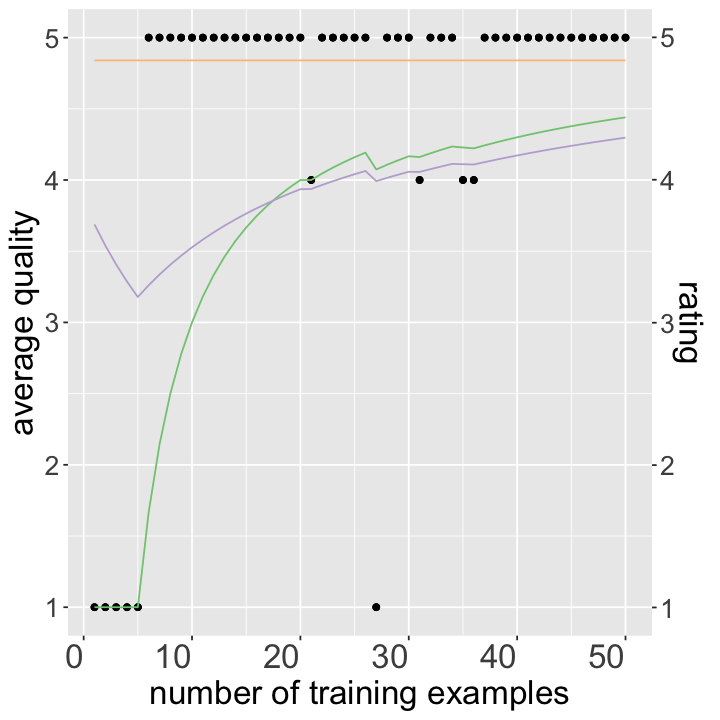

In [63]:
ggplot(df.disp_subset) + 
    geom_point(aes(x=num_train, y=rating)) + 
    geom_line(aes(x=num_train, y=value, colour=method)) +
    scale_y_continuous(
    sec.axis = sec_axis(~ . + 0, name='rating')) +
    theme(text = element_text(size=20),
        axis.text.x = element_text(size=20, angle=0, hjust=1)) +
        xlab("number of training examples") + ylab("average quality") +
    scale_color_brewer(palette="Accent") +
    theme(legend.position = 'none')

In [115]:
df.disp_ratings

item,user,rating,timestamp,n,avg,num_train
<chr>,<chr>,<dbl>,<int>,<int>,<dbl>,<int>
B00PIEHUDS,A123PTCJRDS04X,1,1421539200,140,4.628571,1
B00PIEHUDS,A20TH6CFKHJX9T,1,1421712000,140,4.628571,2
B00PIEHUDS,A1ABZJR261O3VG,1,1421712000,140,4.628571,3
B00PIEHUDS,A3KTFCO2AZFDZE,1,1421798400,140,4.628571,4
B00PIEHUDS,A16CO20FJV58WN,1,1421884800,140,4.628571,5
B00PIEHUDS,A2QOZV6NGI490U,5,1421884800,140,4.628571,6
B00PIEHUDS,A2YLFTEX6WJYEG,5,1421971200,140,4.628571,7
B00PIEHUDS,A6DO0FXYD017V,5,1440460800,140,4.628571,8
B00PIEHUDS,A11BVE0HOX3IT3,5,1440892800,140,4.628571,9
